In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import sys
import h5py
#sys.path.append('/reg/neh/home/tdd14/tmo_repo') #this is a temporary home for the general TMO analysis code
# sys.path.append('/cds/home/p/paris/reconVMI')
# import analyzers_anna as az # this raises a few runtime errors which require some updating
import psana as ps
from matplotlib import pyplot as plt
from tqdm import tqdm
import matplotlib.colors as colors
from scipy.ndimage import gaussian_filter as gf
from scipy import optimize

from matplotlib import cm
from matplotlib.colors import ListedColormap
from scipy.optimize import minimize
from scipy.signal import find_peaks
import scipy
#from scipy.ndimage import gaussian_filter
sys.path.append('/reg/neh/home/tdd14/modules/cart2pol/cart2pol')
import cart2pol
import scipy.misc as scmis
from scipy.optimize import minimize
from scipy.optimize import curve_fit
import scipy.special as sp
from datetime import datetime
import cv2
sys.path.append('/reg/d/psdm/tmo/tmox51020/results/paris/recon')
from recon_funcs import *

/reg/neh/home/tdd14/modules/CPBASEX/pbasex-Python/pbasex/gData.py:55: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if gData['rBF'] is not 'custom':


Hi! I imported. 


In [5]:
def SASE_filter(eV0, spec):
    spec= np.roll(spec, int(len(spec)/2)-np.argmax(spec))
    ft = np.fft.fftshift(np.fft.fft(np.fft.fftshift(np.sqrt(spec))))
    N = len(eV0)
    spectra_f = eV0/(1239.84*(2*np.pi)/2.9979E8/(2*np.pi)*1e-9)
    xt = np.arange(-N/2-1/2,N/2-1/2,1)/np.abs((spectra_f[-1] - spectra_f[0]))
    
    x = np.arange(len(spec))
    mu = len(spec)/2
    sig = 170
    gauss = 1/sig/np.sqrt(2*np.pi)*np.exp(-0.5*((x- mu)/sig)**2)
    gauss = gauss/np.max(gauss)
    
    xf = np.arange(-N/2+1/2,N/2+1/2,1)/((xt[-1] - xt[0])) 
    eV = 1239.84*(2*np.pi*xf)/2.9979E8/(2*np.pi)*1e-9 

    ft = np.fft.fftshift(np.fft.fft(np.fft.fftshift(np.sqrt(spec*gauss))))
    ff = np.fft.ifftshift(np.fft.ifft(ft))
    full = np.fft.ifftshift(np.fft.ifft(ft))
    atoft = np.copy(ft)
    pp = np.argsort((xt-0.8e-15)**2) 
    pp = pp[pp>511][0]
    cut = xt[pp]
    # plt.plot(xt, ft*ft.conj())
    # plt.plot(xt[pp], 100, 'ro')
    # plt.ylim(0,6000)
    # plt.xlim(0,2e-15)
    atoft[np.abs(xt)>cut] = 0
    ato = np.fft.ifftshift(np.fft.ifft(atoft))
    ft[np.abs(xt)<cut] = 0
    ripple = np.fft.ifftshift(np.fft.ifft(ft))
    
    
    return eV, ato, ripple, full

In [27]:
exp = "tmox51020" #"tmoly9120" #'tmox45719'
#exp = 'tmolv1720'
gas_jet = 1
runnum = 121 #122 #121 #112 #105 #76 #73 LY91, 141
#runnum = 328
gmd_min = 0.1 #0.00033

mfn = 25 
gfn = 15
gfsig = 0.985 
gfcart = 0.25 
mfcart = 1

In [28]:
specs = []
gds = []
tmstmps = []

ds=ps.DataSource(exp = exp, run= runnum)
#ds=ps.DataSource(exp = 'tmox51020', run= runnum, filter = lambda evt:evt.timestamp in tt)

run = next(ds.runs())

#opal1 = run.Detector('tmo_opal1') # OPAL camera looking at the holey mirror
gmd = run.Detector("gmd") # gas intensity detector 
timing = run.Detector('timing') # this gives access to evr codes
ebeam = run.Detector("ebeam")
if exp == "tmox51020": opalfzp = run.Detector('tmo_fzpopal') 
if exp == 'tmolv1720': opalfzp = run.Detector('tmo_opal3') 

n = 0

if hasattr(run, 'epicsinfo'):
    epics_strs = [item[0] for item in run.epicsinfo.keys()][1:] # first one is weird
    epics_detectors = [run.Detector(item) for item in epics_strs]    

for nevent, event in enumerate(run.events()):
    #opal1im_i=np.copy(opal1.raw.raw(event))
    gd_i=gmd.raw.energy(event)
    evr=timing.raw.eventcodes(event)

    # identify relevant event codes
    gas=evr[70] # did the gas jet fire
    ir_timed=evr[67] # was the ir laser timed
    ir_misttimed=evr[68] # was the ir laser mis-timed
    
    if gd_i is None or gd_i<gmd_min or (gas != gas_jet): continue #opal1im_i is None 
    
    opalfz= np.copy(opalfzp.raw.image(event)) #np.copy(opal1.raw.image(event)) #np.copy(opal1.raw.raw(event))
    zps_data = opalfz
    zps_pixel = 100+np.argmax(np.sum(zps_data[100:900],axis=1))
    px_2d_width = 25 #spacing to cut the 2d image slice to store. Typically 50 pixel width. 25 on either side
    px_edge_width = 5 #spacing to integrate for the line out. 

    zps_2d = zps_data[zps_pixel-px_2d_width:zps_pixel+px_2d_width][:]
    zps = zps_data[zps_pixel-px_edge_width:zps_pixel+px_edge_width][:].mean(0)#
    zps_bg = zps_data[zps_pixel-px_2d_width:zps_pixel-px_2d_width+px_edge_width][:].mean(0)#
    zps = zps-zps_bg
    #spec = np.squeeze(fastsmooth1(zps,10))
    spec = np.squeeze(zps)
    spec = np.array(np.squeeze(spec) - np.mean(np.squeeze(spec)[800:900])) 
    
    specs.append(spec)
    gds.append(gd_i)
    tmstmps.append(event.timestamp)
    n+=1
    if n%20 == 0: print(n)
    

20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
620
640
660
680
700
720
740
760
780
800
820
840
860
880
900
920
940
960
980
1000
1020
1040
1060
1080
1100
1120
1140
1160
1180
1200
1220
1240
1260
1280
1300
1320
1340
1360
1380
1400
1420
1440
1460
1480
1500
1520
1540
1560
1580
1600
1620
1640
1660
1680
1700
1720
1740
1760
1780
1800
1820
1840
1860
1880
1900
1920
1940
1960
1980
2000
2020
2040
2060
2080
2100
2120
2140
2160
2180
2200
2220
2240
2260
2280
2300
2320
2340
2360
2380
2400
2420
2440
2460
2480
2500
2520
2540
2560
2580
2600
2620
2640
2660
2680
2700
2720
2740
2760
2780
2800
2820
2840
2860
2880
2900
2920
2940
2960
2980
3000
3020
3040
3060
3080
3100
3120
3140
3160
3180
3200
3220
3240
3260
3280
3300
3320
3340
3360
3380
3400
3420
3440
3460
3480
3500
3520
3540
3560
3580
3600
3620
3640
3660
3680
3700
3720
3740
3760
3780
3800
3820
3840
3860
3880
3900
3920
3940
3960
3980
4000
4020
4040
4060
4080
4100
4120
4140
4160
4180
4200
422

KeyboardInterrupt: 

In [29]:
N = 2801
xf = np.arange(-N/2-1/2,N/2-1/2,1)/np.abs(-4.975e-15)/2 #((vNaxis['t_sample'][-1] - vNaxis['t_sample'][0]))
eV = 1239.84*(2*np.pi*xf)/2.9979E8/(2*np.pi)*1e-9 
xeV = pix_2_eV(np.arange(len(specs[0])), pixpereV = 11, spectra_hw0 = 0, spectra_pix0 = 512) #22 for X510, 11 for LV17


In [30]:
pedestals = []
for i in range(len(specs)):
    sss = specs[i]
    sss[sss<0] = 0
    eV, ato, ripple, full = SASE_filter(xeV,sss)
    try:
        x1 = np.where((full*full.conj())<0.1*np.max(full*full.conj()))[0]
        x1 = x1[x1>np.argmax(full*full.conj())] #511
        x1 = np.min(x1)
        cen = np.argmax(full*full.conj())
        dx = x1-cen
        exp_SASE =0.5*np.trapz((ripple*ripple.conj())[cen-dx:cen+dx]/(ato*ato.conj())[cen-dx:cen+dx],eV[cen-dx:cen+dx])
        exp_SPEC = np.trapz((full*full.conj())[cen-dx:cen+dx],eV[cen-dx:cen+dx])
        pedestals.append(np.real(exp_SASE/exp_SPEC)*100)
    except:
        print('oops')

In [25]:
#pedestals127 = pedestals

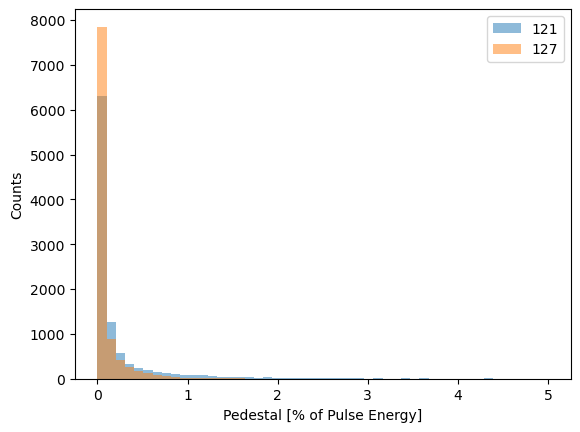

In [31]:
plt.hist(pedestals[:10000], bins = np.linspace(0,5,50), label = '121', alpha = 0.5);
plt.hist(pedestals127[:10000], bins = np.linspace(0,5,50), label = '127', alpha = 0.5);
plt.xlabel('Pedestal [% of Pulse Energy]')
plt.ylabel('Counts')
plt.legend()

Text(0.5, 1.0, 'tmox51020 121')

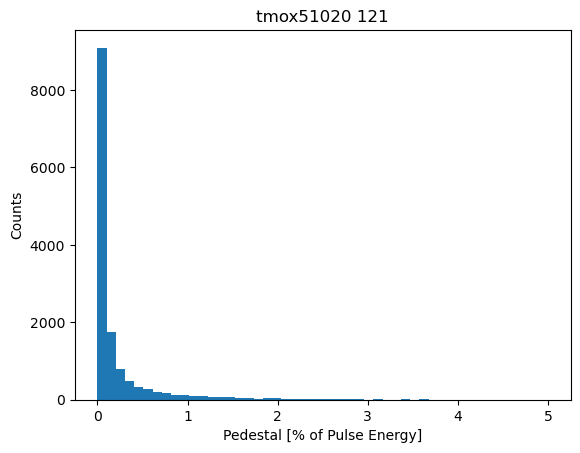

In [32]:
plt.hist(pedestals, bins = np.linspace(0,5,50));
plt.xlabel('Pedestal [% of Pulse Energy]')
plt.ylabel('Counts')
plt.title(exp + ' ' + str(runnum))

In [ ]:
def two_peaks(t, spec): 
    spec[spec<0] = 0
    spec = spec/np.max(spec)
    peakMax = np.max(spec)
    indMax = np.where(spec == peakMax)[0] 
    if len(indMax)>1: indMax = np.max(indMax)
    else: indMax = indMax[0]
    rollnum =  int(len(spec)/2) - indMax
    spec = np.roll(spec, rollnum)
    indMax = int(len(spec)/2)
    t1 = 0
    t2 = 0
    ind1 = 0
    ind2 = 0
    
    for i in range(int(len(t))):
        if t2 != 0 and t1 != 0:
            break
        if i < indMax:
            #print(i, np.trapz(spec[-i:]))
            
            if (spec[indMax-i] <= 0.5) & (t1 == 0):
                t1 = t[indMax-i]
                ind1 = indMax-i
            elif (spec[indMax+i] <= 0.5) & (t2 == 0):
                t2 = t[indMax+i]  
                ind2 = indMax+i
                
    spec = spec/np.sum(spec)
    area = np.trapz(spec[ind1:ind2]) #area in the FWHM
    return t2-t1, area, ind1-rollnum, ind2-rollnum

In [ ]:
areas = []
for i in range(len(specs)):
    fw, area, ind1, ind2 = two_peaks(np.arange(len(specs[i])),specs[i])
    areas.append(area)

In [ ]:
specs = np.array(specs)
areas = np.array(areas)

In [ ]:
N = 2801
xf = np.arange(-N/2-1/2,N/2-1/2,1)/np.abs(-4.975e-15)/2 #((vNaxis['t_sample'][-1] - vNaxis['t_sample'][0]))
eV = 1239.84*(2*np.pi*xf)/2.9979E8/(2*np.pi)*1e-9 
xeV = pix_2_eV(np.arange(len(specs[0])), pixpereV = 22, spectra_hw0 = 0, spectra_pix0 = 512)


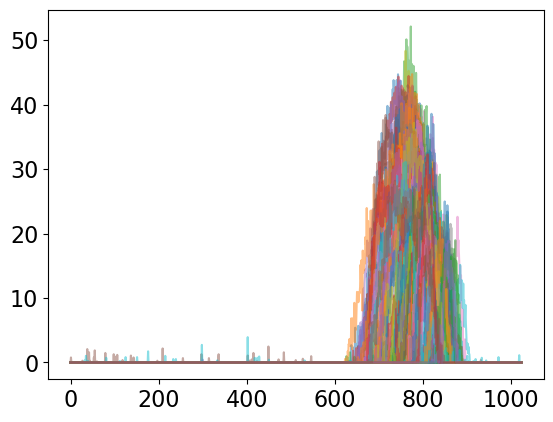

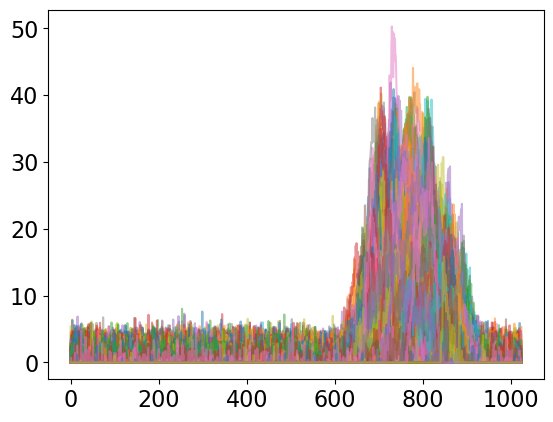

In [242]:
for n in np.where((0.72<np.array(areas)))[0]:
    plt.plot(specs[n], alpha = 0.5)
plt.show()    

for n in np.where((np.array(areas)<0.72))[0]:
    plt.plot(specs[n], alpha = 0.5)
plt.show()   

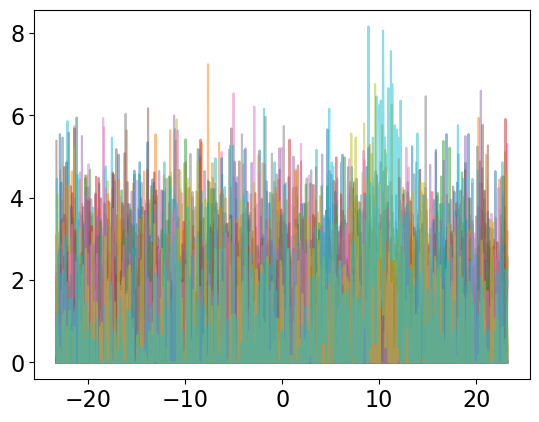

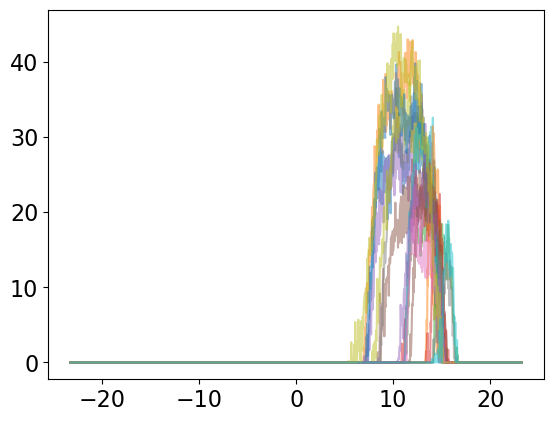

In [243]:
for n in range(20):
    plt.plot(xeV,specs[np.argsort(areas)[n]], alpha = 0.5)
plt.show()  

for n in range(20):
    plt.plot(xeV,specs[np.argsort(-areas)[n]], alpha = 0.5)
plt.show()  

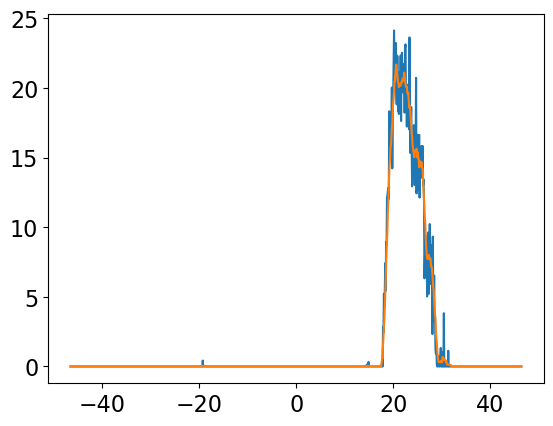

In [391]:
i = 39 #13,19
#35
#37,43 is 1%
#47?
#49 0.2%

#2,0

plt.plot(xeV,specs[np.argsort(-areas)[i]])
plt.plot(xeV,fastsmooth1(specs[np.argsort(-areas)[i]],10))


In [211]:
font = {'size'   : 16}
plt.rc('font', **font)

In [397]:
specs.shape

(1865, 1024)

In [398]:
np.argmax(np.mean(specs[(0.72<np.array(areas)),:],axis=0))

806

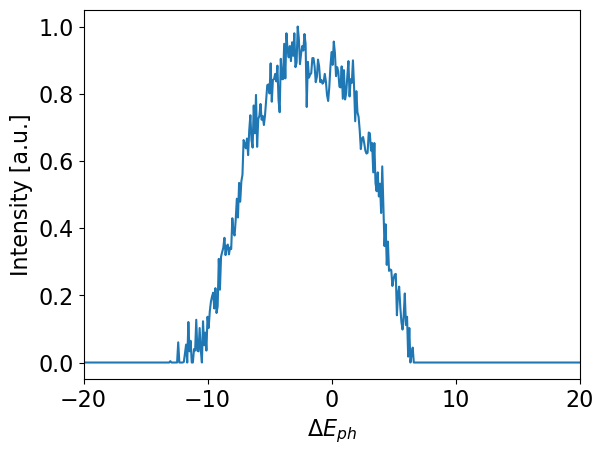

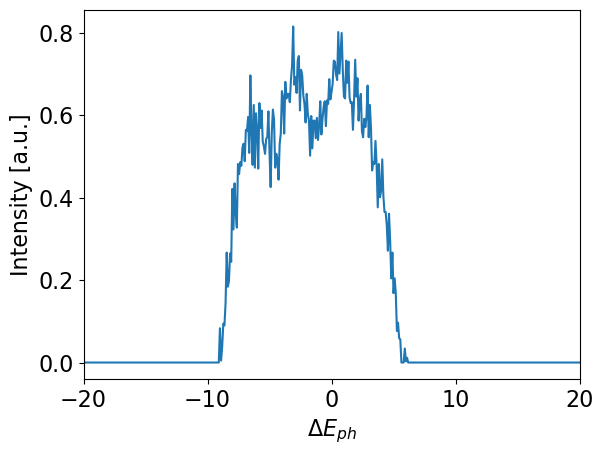

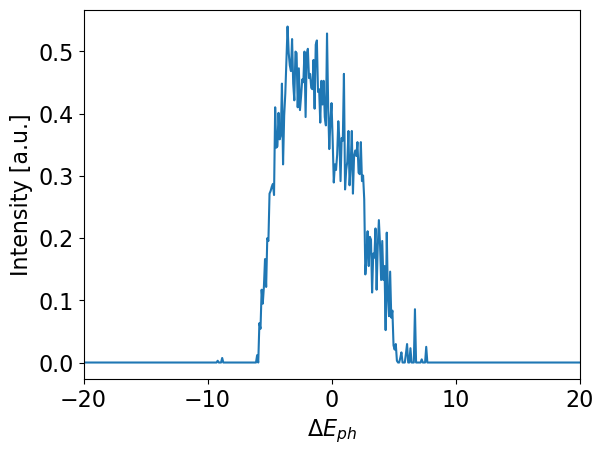

In [420]:
i = 18
maxsc = np.max(specs[np.argsort(-areas)[i]])
plt.plot(xeV,np.roll(specs[np.argsort(-areas)[i]]/maxsc,512-773))
#plt.plot(eV,full*full.conj(), label = 'full')
plt.xlabel('$\Delta E_{ph}$')
plt.ylabel('Intensity [a.u.]')
plt.xlim(-20,20)
plt.show()


i = 0
plt.plot(xeV,np.roll(specs[np.argsort(-areas)[i]]/maxsc,512-773))
plt.xlabel('$\Delta E_{ph}$')
plt.ylabel('Intensity [a.u.]')
plt.xlim(-20,20)
plt.show()



i = 39
plt.plot(xeV,np.roll(specs[np.argsort(-areas)[i]]/maxsc,512-773))
plt.xlabel('$\Delta E_{ph}$')
plt.ylabel('Intensity [a.u.]')
plt.xlim(-20,20)
plt.show()

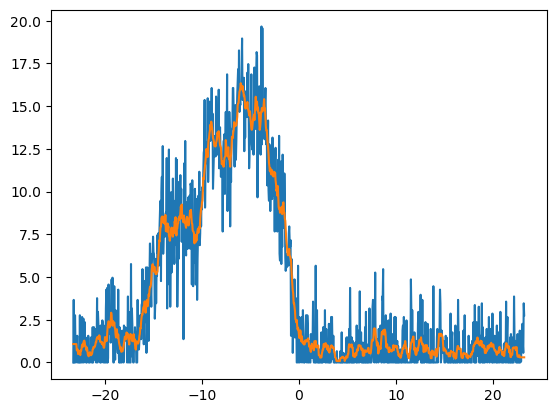

In [123]:
i = 7
plt.plot(xeV,specs[np.argsort(areas)[i]])
plt.plot(xeV,fastsmooth1(specs[np.argsort(areas)[i]],10))


In [323]:
N = 2801
xf = np.arange(-N/2-1/2,N/2-1/2,1)/np.abs(-4.975e-15)/2 #((vNaxis['t_sample'][-1] - vNaxis['t_sample'][0]))
eV = 1239.84*(2*np.pi*xf)/2.9979E8/(2*np.pi)*1e-9 
xeV = pix_2_eV(np.arange(len(specs[0])), pixpereV = 11, spectra_hw0 = 0, spectra_pix0 = 512) #22 for X510, 11 for LV17


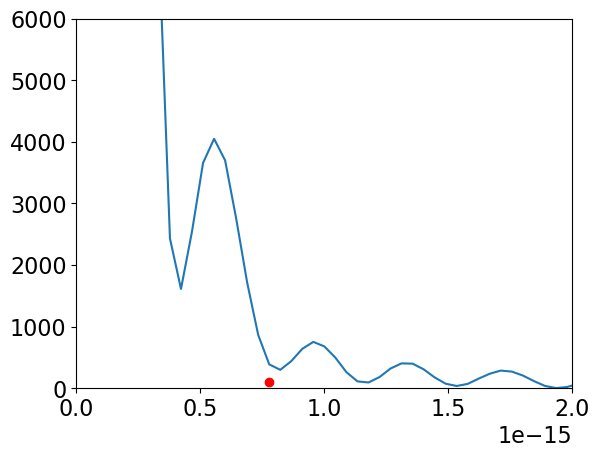

In [441]:
eV, ato, ripple, full = SASE_filter(xeV,specs[np.argsort(-areas)[39]])


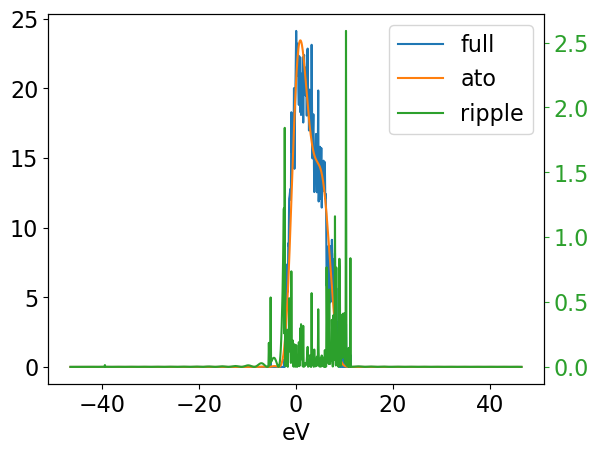

In [407]:
l1, = plt.plot(eV,full*full.conj(), label = 'full')
l3, = plt.plot(eV,ato*ato.conj(), label = 'ato')
plt.xlabel('eV')
ax = plt.twinx()
l2, = plt.plot(eV,ripple*ripple.conj(), label = 'ripple', color = 'tab:green')
plt.legend(handles = [l1,l3,l2]) #, [l1[0].get_label(),l2[0].get_label()])
plt.xlabel('eV')
ax.tick_params(axis='y', colors='tab:green')

plt.show()


In [408]:
x1 = np.where((full*full.conj())<0.1*np.max(full*full.conj()))[0]
x1 = x1[x1>np.argmax(full*full.conj())] #511
x1 = np.min(x1)
cen = np.argmax(full*full.conj())
dx = x1-cen
exp_SASE =0.5*np.trapz((ripple*ripple.conj())[cen-dx:cen+dx]/(ato*ato.conj())[cen-dx:cen+dx],eV[cen-dx:cen+dx])
exp_SPEC = np.trapz((full*full.conj())[cen-dx:cen+dx],eV[cen-dx:cen+dx])
np.real(exp_SASE/exp_SPEC)*100

7.874749634686093

In [381]:
eV[x1]

4.499999999999998

In [414]:
spec_look = np.array(specs[(0.72<np.array(areas)),:])
spectra_hw0 = 875. # according to this elog entry http://physics-elog.slac.stanford.edu/lclselog/show.jsp?dir=/2022/09/28.02&pos=2022-02-28T12:15:07 ​

spectra_dhwdpix = 1./11. # 11 pixels per eV (also calibr scan near this elog entry) http://physics-elog.slac.stanford.edu/lclselog/show.jsp?dir=/2022/08/23.02&pos=2022-02-23T23:59:25 ​

spectra_pix0 = np.argmax(np.std(spec_look,axis=0))

spectra_hws = spectra_dhwdpix * (np.arange(spec_look.shape[1])-spectra_pix0) #+spectra_hw0 

spectra_hws_eV = spectra_hws

In [422]:
dat = np.load('/cds/home/p/paris/cascade/tmolv1720_325_326_cascade_11Jun2023.npy', allow_pickle = True)[()] 
spec = dat['spec']
es = dat['es']
es2 = np.copy(es)
es2[es2<4491.5] = np.nan
L3slice = []
m = np.nanmean(es2)
#m = np.nanpercentile(es2,50)
s = np.nanstd(es2)
for i in range(len(dat['runs'])):
    if np.abs(m-es[i]) <= s:
        L3slice.append(True)
    else:
        L3slice.append(False)
L3slice = np.array(L3slice)

/tmp/ipykernel_7187/1433071135.py:5: RuntimeWarning: invalid value encountered in less
  es2[es2<4491.5] = np.nan


In [453]:
pedestals = []
for i in range(len(spec[L3slice])):
    sss = spec[L3slice][i,:]
    sss[sss<0] = 0
    eV, ato, ripple, full = SASE_filter(xeV,sss)
    try:
        x1 = np.where((full*full.conj())<0.1*np.max(full*full.conj()))[0]
        x1 = x1[x1>np.argmax(full*full.conj())] #511
        x1 = np.min(x1)
        cen = np.argmax(full*full.conj())
        dx = x1-cen
        exp_SASE =0.5*np.trapz((ripple*ripple.conj())[cen-dx:cen+dx]/(ato*ato.conj())[cen-dx:cen+dx],eV[cen-dx:cen+dx])
        exp_SPEC = np.trapz((full*full.conj())[cen-dx:cen+dx],eV[cen-dx:cen+dx])
        pedestals.append(np.real(exp_SASE/exp_SPEC)*100)
    except:
        print('oops')
    

Text(0, 0.5, 'Counts')

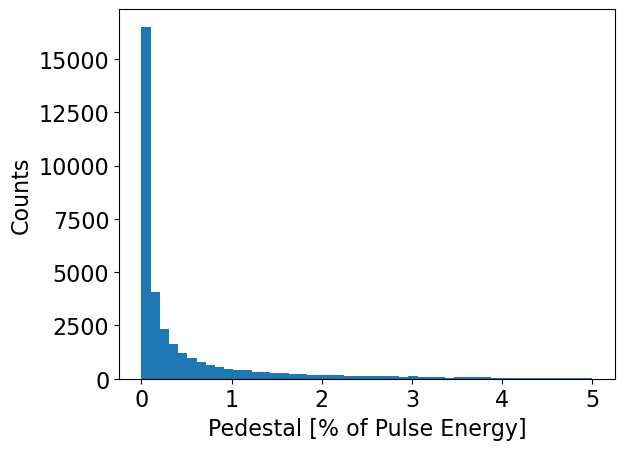

In [457]:
plt.hist(pedestals, bins = np.linspace(0,5,50));
plt.xlabel('Pedestal [% of Pulse Energy]')
plt.ylabel('Counts')

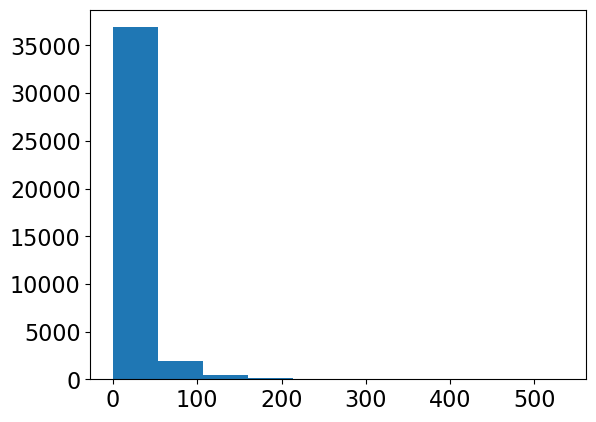

In [456]:
plt.hist(pedestals);

In [467]:
np.percentile(pedestals,75)

1.1130340625782247